In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scanpy as sc
import sklearn
from io import StringIO
from Bio import Phylo
import re

from ete3 import Tree
from matplotlib.colors import ListedColormap

import phylovelo as pv


/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
data_path = '/data3/wangkun/phylovelo_datasets/embryo/'

In [60]:
count = pd.read_csv(data_path+'embryo1/scRNA_raw_counts.csv', index_col=0).T
metadata = pd.read_csv(data_path+'embryo1/scRNA_metadata.csv', index_col=0)

In [67]:
from ete3 import Tree
from io import StringIO

with open(data_path+'trees/embryo1_all.newick', 'r') as f:
    tree_nwk = f.readline()
t = Tree(tree_nwk)
f = StringIO(t.write())
tree = Phylo.read(f, 'newick')
f.close()
terminals = [i.name for i in tree.get_terminals()]
cell_names = list(set(count.index).intersection(set(terminals)))
count = count.loc[cell_names]

tree_depths = tree.depths()
depths_map = dict()
for i in tree_depths:
    depths_map[i.name] = tree_depths[i]
depths = [depths_map[i] for i in cell_names]

In [68]:
em = 1
alleletab = pd.read_csv(data_path + f'GSM{3302825+em}_embryo{em}_alleleTable.txt', sep='\t', index_col=0) 
mutnum = []
for bc in cell_names:
    sel_alleles = alleletab.loc[f'{bc}-1']
    if len(sel_alleles.shape) == 2:
        sel_alleles = '_'.join(sel_alleles['allele1']).split('_')
    else:
        sel_alleles = sel_alleles['allele1'].split('_')

    mutnum.append(len(sel_alleles)-sel_alleles.count('None'))

In [69]:
import anndata as ad
adata = ad.AnnData(count)
sd = pv.scData(count=pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names))
sc.pp.filter_genes(adata, min_counts=20)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sd.x_normed = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
sd.phylo_tree = tree
sd.drop_duplicate_genes(target='x_normed')
sd.cell_states = sd.cell_states = metadata.loc[sd.count.index]['cluster'].to_numpy()
sd.dimensionality_reduction(target='x_normed', method='umap')



In [70]:
pv.velocity_inference(sd, mutnum, cutoff=0.97, target='x_normed')

  0%|          | 0/14546 [00:00<?, ?it/s]

In [71]:
pv.velocity_embedding(sd, target='x_normed', n_neigh=800)

  0%|          | 0/6328 [00:00<?, ?it/s]

In [72]:
from matplotlib import font_manager
import matplotlib.patheffects as pe

font = font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF')
def label_name(loc, cell_types, ax, fontsize=12, font='DejaVu Sans'):
    loc = np.array(loc)
    cell_types = np.array(cell_types)
    for i in set(cell_types):
        loci = loc[cell_types==i].mean(0)
        ax.text(*loci, i, fontsize=fontsize, font=font,c='black', ha='center', va='center',
                path_effects=[pe.withStroke(linewidth=2, foreground="white")])
    return ax
cell_state_map = {0:'trophoblast stem cells',1:'neural ectoderm anterior',2:'primitive streak late',3:'anterior primitive streak',4:'primitive\ndefinitive endoderm',5:'allantois',6:'secondary heart field\nsplanchnic lateral plate',7:'gut endoderm',8:'ectoderm early 1',9:'primitive blood early',10:'preplacodalectoderm',11:'neural ectoderm posterior',12:'posterior lateral plate mesoderm',13:'hematopoietic\nendothelial progenitors',14:'parietal endoderm',15:'amnion mesoderm early',16:'surface ectoderm',17:'epiblast',18:'somites',19:'ectoderm early',20:'splanchnic lateral plate\nanterior paraxialmesoderm',21:'primitive heart tube',22:'primitive blood late',23:'notochord',24:'fore/midbrain',25:'distal extraembryonic ectoderm',26:'neuromesodermal progenitor early',27:'primordial germ cells',28:'differentiated trophoblasts',29:'visceral endoderm early',30:'presomitic mesoderm',31:'neuromesodermal progenitor late',32:'angioblasts',33:'neural crest',34:'pharyngeal arch mesoderm',35:'similar to neural crest',36:'primitive blood progenitors',37:'primitive streak early',38:'node',39:'future spinal cord',40:'visceral endoderm late',41:'amnion mesoderm late'}
colors = ['#5D8AA8','#F0F8FF','#E32636','#E52B50','#FFBF00','#A4C639','#8DB600','#FBCEB1','#7FFFD4','#4B5320','#3B444B','#E9D66B','#B2BEB5','#87A96B','#FF9966','#6D351A','#007FFF','#89CFF0','#A1CAF1','#F4C2C2','#FFD12A','#848482','#98777B','#F5F5DC','#3D2B1F','#000000','#318CE7','#FAF0BE','#0000FF','#DE5D83','#79443B','#CC0000','#B5A642','#66FF00','#BF94E4','#C32148','#FF007F','#08E8DE','#D19FE8','#004225','#CD7F32','#964B00','#FFC1CC','#E7FEFF','#F0DC82','#800020','#DEB887','#CC5500']

Text(0.5, 1.0, 'Embryo1')

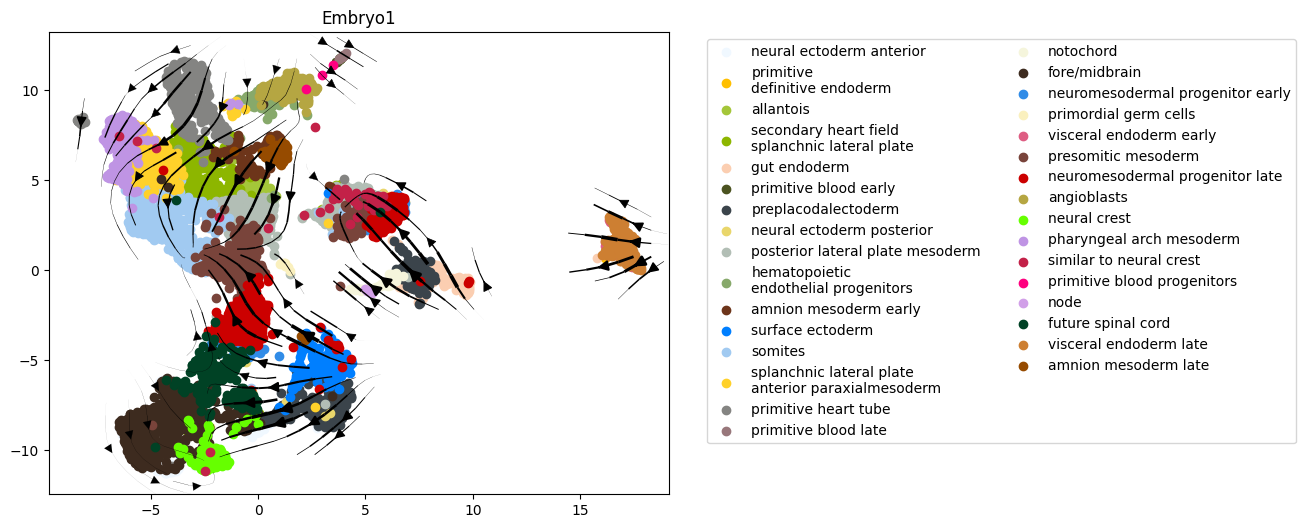

In [73]:
fig, ax = plt.subplots(figsize=(8,6))
all_states = list(set(sd.cell_states))
all_states.sort()
for i in all_states:
    ax.scatter(sd.Xdr.loc[sd.cell_states==i].iloc[:,0], sd.Xdr.loc[sd.cell_states==i].iloc[:,1], c=colors[i], label=cell_state_map[i])
pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=1, lw_coef=8000, arrowsize=1.5)
ax.legend(ncol=2, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# label_name(sd.Xdr, [cell_state_map[i] for i in sd.cell_states], ax, font=font, fontsize=8)
ax.set_title('Embryo1')

In [106]:
from copy import deepcopy
sd_shuffle = deepcopy(sd)
np.random.shuffle(mutnum)
pv.velocity_inference(sd_shuffle, mutnum, cutoff=0.97, target='x_normed')

  0%|          | 0/14546 [00:00<?, ?it/s]

In [109]:

v_megs = pd.DataFrame(data=sd_shuffle.velocity, index=sd_shuffle.x_normed.columns, columns=['velocity']).loc[sd_shuffle.megs]
v_megs['p_value']=sd_shuffle.pvals.T
v_megs['q_value']=sd_shuffle.qvals.T
v_megs.to_csv('./megs/embryo1_all_shuffle.csv')

In [74]:
v_megs = pd.DataFrame(data=sd.velocity, index=sd.x_normed.columns, columns=['velocity']).loc[sd.megs]
v_megs['p_value']=sd.pvals.T
v_megs['q_value']=sd.qvals.T
v_megs.to_csv('./megs/embryo1_all_mutnum.csv')

<AxesSubplot: >

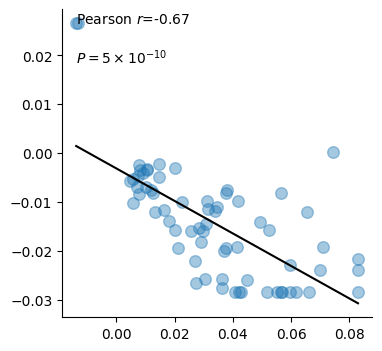

In [77]:
fig, ax = plt.subplots(figsize=(4, 4))
cnt = 0

v1, v2 = [], []
common_genes = list(set(v_megs.index).intersection(vels_em1.index))
for gene in common_genes:
    try:
        v1.append(v_megs['velocity'][gene])
    except:
        v1.append(0)
    try:
        v2.append(vels_em1['velocity'][gene])
    except:
        v2.append(0)

plot_overlap_vels(v1, v2, ax)

In [86]:
vels_em1 = pd.read_csv('./megs/embryo1_all.csv', index_col=0)
vels_em2 = pd.read_csv('./megs/embryo2_all.csv', index_col=0)
vels_em3 = pd.read_csv('./megs/embryo3_all.csv', index_col=0)
vels_em6 = pd.read_csv('./megs/embryo6_all.csv', index_col=0)

In [94]:
vels_em1 = pd.read_csv('./megs/embryo1_all_mutnum.csv', index_col=0)
vels_em2 = pd.read_csv('./megs/embryo2_all_mutnum.csv', index_col=0)
vels_em3 = pd.read_csv('./megs/embryo3_all_mutnum.csv', index_col=0)
vels_em6 = pd.read_csv('./megs/embryo6_all_mutnum.csv', index_col=0)

In [101]:
vels_em3.shape

(428, 3)

In [95]:
vels = [vels_em1, vels_em2, vels_em3, [], [], vels_em6]

In [96]:
from itertools import combinations

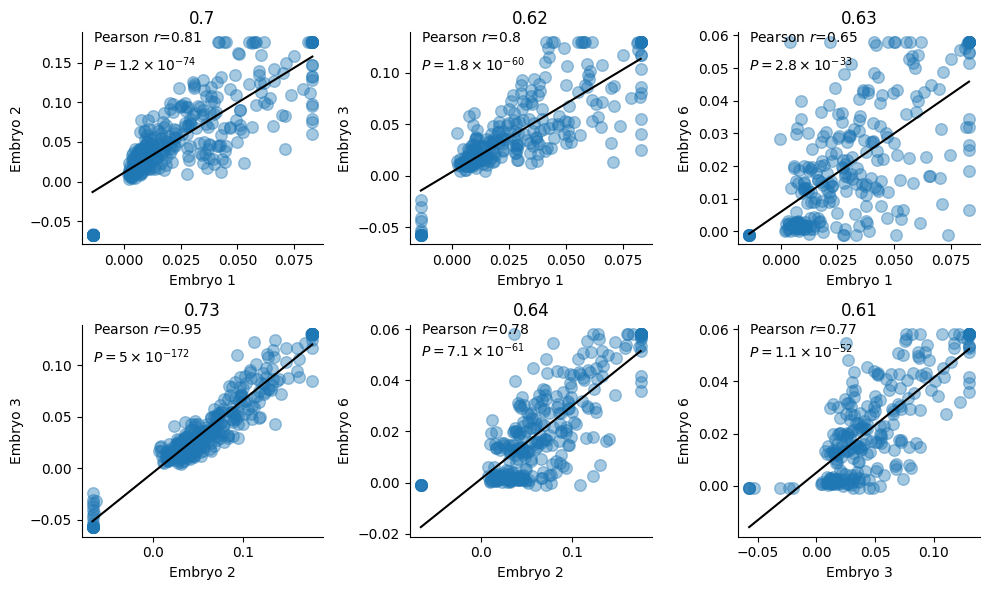

In [102]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
cnt = 0
for i, j in combinations([1,2,3,6], 2):
    v1, v2 = [], []
    common_genes = list(set(vels[i-1].index).intersection(vels[j-1].index))
    for gene in common_genes:
        try:
            v1.append(vels[i-1]['velocity'][gene])
        except:
            v1.append(0)
        try:
            v2.append(vels[j-1]['velocity'][gene])
        except:
            v2.append(0)
    
    plot_overlap_vels(v1, v2, ax[cnt//3][cnt%3])
    ax[cnt//3][cnt%3].set_xlabel(f'Embryo {i}')
    ax[cnt//3][cnt%3].set_ylabel(f'Embryo {j}')
    ax[cnt//3][cnt%3].set_title('{:.2g}'.format(2*len(common_genes)/(len(vels[i-1].index)+len(vels[j-1].index))))
    cnt += 1
plt.tight_layout()

In [98]:
import numpy as np
from scipy.stats import pearsonr

def plot_overlap_vels(v1, v2, ax):
    x = v1
    y = v2

    a, b = np.polyfit(x, y, deg=1)
    y_est = a * np.linspace(min(x),max(x),60) + b

    # fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(x, y, alpha=0.4, s=70)
    ax.plot(np.linspace(min(x),max(x),60), y_est, '-', c='k')
    # ax.set_xlabel('Velocity Embryo2')
    # ax.set_ylabel('Velocity Embryo3')
    r, pval = pearsonr(x, y)
    ax.text(min(x)*1, max(y), r"Pearson $r$={:.2g}".format(r), fontsize=10)
    try:
        ax.text(min(x)*1, max(y)-(max(y)-min(y))*0.15, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=10)
    except:
        ax.text(min(x)*1, max(y)-(max(y)-min(y))*0.15, r'$P={:.2f}$'.format(pval))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax